
# How to automate closed-loop hardware optimization
**Closed-loop optimization without complete system models**

Boulder Opal contains automated closed-loop optimization tools that do not require a complete understanding of the workings of your quantum system. These tools allow you to run optimizations incorporating input data rather than building a detailed model of your system.

This notebook will show how you can find optimized solutions using Boulder Opal's [closed-loop optimization module](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop) directly interacting with an experiment (here, simulated).
It shows how to set up a closed-loop optimization depending on the needs of your optimization.

## Closed-loop optimization framework

You can use the automated closed-loop optimizers to create a closed-optimization loop where the optimizer communicates with the experimental apparatus without your direct involvement. In this kind of setting, your experimental apparatus produces an initial set of results, which it sends to the optimizer. Using this information, the optimizer produces a set of improved test points that it recommends back to the experimental apparatus. The results corresponding to these test points are resent to the optimizer, and the cycle repeats itself until any of the results has a sufficiently low cost function value, or until it meets any other ending condition that you imposed. This setup is illustrated in the figure below.



## Summary workflow

### 1. Set up an interface with the experiment

A closed-loop optimization attempts to find a set of parameters that are capable of minimizing the value of a cost function. The parameters are real numbers that represent quantities that you can control and change from experiment to experiment. This means that the exact nature of the parameters depends on the problem that you are trying to solve, but in the context of quantum control they typically represent the values of a piecewise-constant control pulse.

From the result of each experiment, you must obtain a cost, a real number that represents a quantity that you want to minimize. The exact nature of the cost also depends on the problem you want to solve, but in the context of quantum control the cost will typically be an infidelity with respect to the ideal result of the operation.

#### Establish experimental batching
In some cases it is advantageous to configure the optimizer to accept multiple test point/measurement pairs in each step, such as measurements with substantial network latency on a cloud quantum computer.

### 2. Configure closed-loop optimization

#### Determine initial seed

Before starting the closed-loop optimization, you will need to collect a few initial results for the optimizer to use as a starting point.
Create a collection of parameter sets that are valid for the problem that you are considering, and store them in a NumPy array.
In the case of quantum control, this will typically mean a range of pulse shapes to subject the qubits to.

#### Select and initialize the optimizer

Create an object with the optimizer that you want to use, passing the optimizable parameter bounds and any necessary configuration for it.
Details of all available Boulder Opal automated optimizers are available in the [closed-loop optimization reference documentation](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop).

### 3. Execute optimization

During the course of the closed-loop optimization, the optimizer will generate test parameter sets in order to execute experiments with them.

If you can define the interface with your experimental apparatus as a cost function which takes a set of parameters (as a NumPy array of shape `(test_point_count, parameter_count)`) and returns the associated cost of each set (as a 1D NumPy array of length `test_point_count`), you can use `boulderopal.closed_loop.optimize` to easily set up and run the whole optimization.
Provide it with the `cost_function` that you defined, the `initial_parameters`, and the `optimizer` that you want to use.
The function will start an iteration cycle, calling the cost function and generating new test points to explore the parameter landscape  until any of the convergence criteria are met.

If your experimental set up is more complex and you need to further configure the optimization loop, you can define your own calling `boulderopal.closed_loop.step` at each iteration.

In [1]:
from functools import partial
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

# Mute messages from Boulder Opal calls.
bo.cloud.set_verbosity("QUIET")

## Example: Designing an optimal control for a qubit subject to unknown control operators with an automated closed-loop optimization

Consider a qubit whose precise Hamiltonian is unknown to you. Specifically, suppose that you want to create an optimized X gate but your Hamiltonian contains unknown terms:

$$ H(t) = \frac{\Omega(t)}{2} \left( \sigma_x + Q_\text{unknown} \right). $$

In the previous equation, $\Omega(t)$ define the control pulses, and $Q_\textrm{unknown}$ are extra unknown terms that appear when applying your control.  This example shows how you can find the optimal pulse for this system without having to learn the form of this extra term.

###  Set up an interface with the experiment

In a practical situation, you'll be obtaining the data from your experimental equipment.
In this example, the experimental results are [simulated using Boulder Opal](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-simulate-quantum-dynamics-for-noiseless-systems-using-graphs).
In either case, you'll need a function that accepts sets of parameters (the piecewise-constant values of $\Omega(t)$) and returns their corresponding infidelities with respect to the target X gate, which act as the cost.
The function in the following code block implements this with input and output arrays with the appropriate shapes.

In [2]:
# Define standard deviation of the errors in the experimental results.
sigma = 0.01

# Define standard matrices.
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Define control parameters.
duration = 1e-6  # s

# Create a random unknown operator.
rng = np.random.default_rng(seed=0)
phi = rng.uniform(-np.pi, np.pi)
u = rng.uniform(-1, 1)
Q_unknown = (
    u * sigma_z + np.sqrt(1 - u**2) * (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
) / 4


# Define simulation of a quantum experiment to use in the optimization loop.
def run_experiments(omegas, rng):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity plus
    a Gaussian error.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """

    # Create the graph with the dynamics of the system.
    graph = bo.Graph()
    signal = graph.pwc_signal(values=omegas, duration=duration)
    graph.infidelity_pwc(
        hamiltonian=0.5 * signal * (sigma_x + Q_unknown),
        target=graph.target(operator=sigma_x),
        name="infidelities",
    )

    # Run the simulation.
    result = bo.execute_graph(graph=graph, output_node_names="infidelities")

    # Add error to the measurement and cap it between [0, 1].
    error_values = rng.normal(loc=0, scale=sigma, size=len(omegas))
    infidelities = np.clip(
        result["output"]["infidelities"]["value"] + error_values, 0, 1
    )

    # Use the same uncertainty for all results.
    uncertainties = np.repeat(sigma, len(omegas))

    return np.array([infidelities, uncertainties])

### Configure closed-loop optimization

#### Determine initial seed

After defining the experimental interface, you need to obtain a set of initial results.
You will use these as the initial input for the automated closed-loop optimization algorithm.
The distribution of the initial test points will influence the convergence of the algorithm, with the optimal distribution depending on the particular problem to be solved. 
Common choices are to sample a uniform distribution or a distribution centered about some point of interest (such as default or model-obtained values). 

In this case we use 20 initial parameter sets, each one representing a pulse with a constant value. 

In [3]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define number of segments in the control.
segment_count = 10

# Define initial parameter set as constant controls with piecewise constant segments.
max_omega = 5 * np.pi / duration
initial_parameters = (
    (max_omega / 4)
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

#### Select and initialize the optimizer
This example uses the object `boulderopal.closed_loop.Cmaes` to set up an automated closed-loop optimization that uses the [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES) algorithm.
You can use [analogous objects to perform the optimization with other methods](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop), although the set of arguments will vary with the method.

In [4]:
# Define bounds for all optimization parameters.
bounds = np.repeat([[-1, 1]], segment_count, axis=0) * max_omega

# Create CMA-ES optimizer.
cmaes_optimizer = bo.closed_loop.Cmaes(bounds=bo.closed_loop.Bounds(bounds), seed=0)

### Execute optimization

The `boulderopal.closed_loop.optimize` function will iterate executing the cost function with new test points until it converges to the `target_cost` or reaches the `max_iteration_count`.

In [5]:
# Optimization halting conditions.
target_cost = 2 * sigma
max_iteration_count = 20

# Set RNG for `run_experiments` to have determistic results.
_run_experiments = partial(run_experiments, rng=np.random.default_rng(0))

# Run the closed-loop optimization.
clo_result = bo.closed_loop.optimize(
    cost_function=_run_experiments,
    initial_parameters=initial_parameters,
    optimizer=cmaes_optimizer,
    target_cost=target_cost,
    max_iteration_count=max_iteration_count,
)

Running closed loop optimization
-----------------------------------------------
  Optimizer             : CMA-ES
  Number of test points : 20
  Number of parameters  : 10
-----------------------------------------------

Calling cost function…
  Initial best cost: 2.538e-02

Running optimizer…
Calling cost function…
  Best cost after 1 iterations: 2.538e-02

Running optimizer…
Calling cost function…
  Best cost after 2 iterations: 2.538e-02

Running optimizer…
Calling cost function…
  Best cost after 3 iterations: 2.538e-02

Running optimizer…
Calling cost function…
  Best cost after 4 iterations: 2.515e-02

Running optimizer…
Calling cost function…
  Best cost after 5 iterations: 2.515e-02

Running optimizer…
Calling cost function…
  Best cost after 6 iterations: 2.515e-02

Running optimizer…
Calling cost function…
  Best cost after 7 iterations: 2.515e-02

Running optimizer…
Calling cost function…
  Best cost after 8 iterations: 2.515e-02

Running optimizer…
Calling cost function…
  

Optimized infidelity: 0.01153


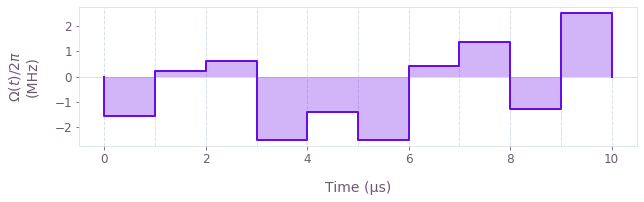

In [6]:
print(f"Optimized infidelity: {clo_result['cost']:.5f}")
qv.plot_controls(
    {
        r"$\Omega(t)$": {
            "durations": np.repeat([duration], len(clo_result["parameters"])),
            "values": clo_result["parameters"],
        }
    }
)

## Example: Designing an optimal control for a qubit subject to unknown control operators with a custom loop

In this section we employ the same model as in the previous examples, but we will set up our custom closed-loop optimization loop using `boulderopal.closed_loop.step`.
You can use this approach when `boulderopal.closed_loop.optimize` is not flexible enough for your needs.
In this case, we will assume that the experiment is not capable of executing control pulse values close to zero.

###  Set up an interface with the experiment

As this example deals with the same problem as before, we will reuse `run_experiments` as the cost function, and will seed a Gaussian process optimizer with the same set of initial test points. In order to deal with the limitation on small control pulse values, we define a function that removes test points that contain values below the threshold.

This method tries to fit a Gaussian process model to the data provided.
The optimizer object takes the `length_scale_bounds`: the bounds of the length scales of the model's Gaussian kernel, which are tuned while training the model during the optimization.
Roughly speaking, the amount a parameter needs to change to impact the optimization cost should lie within these length scale bounds.

In [7]:
threshold_omega = 0.07 * max_omega


def select_valid_test_points(test_points):
    valid_indices = np.all(np.abs(test_points) >= threshold_omega, axis=1)
    return test_points[valid_indices]

### Execute optimization

Now we set up the optimization loop.
The first call to  `boulderopal.closed_loop.step` takes in the optimizer configuration (defined above), and the initial set of results.
Subsequent calls to the function take the optimizer state returned by the last function call.

We set up the early stop conditions in the loop so it halts when the optimizer converges to the `target_cost` or reaches the `max_iteration_count`.

In [8]:
# Create Gaussian Process optimizer.
gp_optimizer = bo.closed_loop.GaussianProcess(
    bounds=bo.closed_loop.Bounds(bounds),
    length_scale_bounds=np.repeat([[1e-5, 1e5]], segment_count, axis=0),
    seed=1,
)

# Reset RNG for `run_experiments` to have determistic results.
_run_experiments = partial(run_experiments, rng=np.random.default_rng(0))

print("Calling cost function…")
parameters = select_valid_test_points(initial_parameters)
costs, uncertainties = _run_experiments(parameters)
best_cost, best_parameters = min(zip(costs, parameters), key=lambda x: x[0])
print(f"  Initial best cost: {best_cost:.3e}")

print("\nRunning optimizer…")
step = bo.closed_loop.step(
    optimizer=gp_optimizer,
    results=bo.closed_loop.Results(parameters, costs, uncertainties),
    test_point_count=test_point_count,
)

for iteration in range(1, max_iteration_count):
    parameters = select_valid_test_points(step["test_points"])
    if len(parameters) == 0:
        # If there are no valid test points, we set results to None,
        # which will make bo.closed_loop.step generate new test points.
        results = None

    else:
        print("Calling cost function…")
        costs, uncertainties = _run_experiments(parameters)
        results = bo.closed_loop.Results(parameters, costs, uncertainties)

        _best_cost, _best_parameters = min(zip(costs, parameters), key=lambda x: x[0])
        if _best_cost < best_cost:
            best_cost, best_parameters = _best_cost, _best_parameters
        print(f"  Best cost after {iteration} iterations: {best_cost:.3e}")

        if best_cost < target_cost:
            print("\nTarget cost reached. Stopping the optimization.")
            break

    print("\nRunning optimizer…")
    step = bo.closed_loop.step(
        optimizer=step["state"], results=results, test_point_count=test_point_count
    )

Calling cost function…
  Initial best cost: 2.459e-02

Running optimizer…
Calling cost function…
  Best cost after 1 iterations: 2.459e-02

Running optimizer…
Calling cost function…
  Best cost after 2 iterations: 2.459e-02

Running optimizer…
Calling cost function…
  Best cost after 3 iterations: 2.379e-02

Running optimizer…
Calling cost function…
  Best cost after 4 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 5 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 6 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 7 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 8 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 9 iterations: 2.204e-02

Running optimizer…
Calling cost function…
  Best cost after 10 iterations: 1.678e-02

Target cost reached. Stopping the optimization.



Optimized infidelity: 0.01678


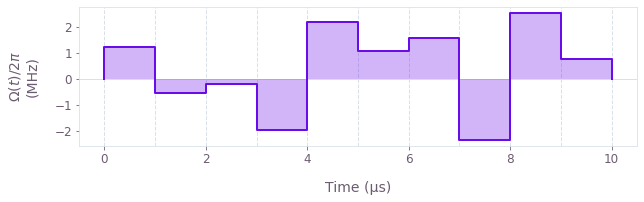

In [9]:
print(f"\nOptimized infidelity: {best_cost:.5f}")
qv.plot_controls(
    {
        r"$\Omega(t)$": {
            "durations": np.repeat([duration], len(best_parameters)),
            "values": best_parameters,
        }
    }
)

## Summary

The automated closed-loop optimization tools from Boulder Opal allow you to obtain optimal controls even without complete knowledge about the dynamics of the system. These examples demonstrate that the various optimizers obtain optimized controls capable of yielding low infidelities without any explicit assumptions about the Hamiltonian.

Depending on your optimization problem, a particular optimizer might be better suited to quickly find good optimization parameters.
You can find all the available closed-loop optimizers in the [reference documentation](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/closed_loop).
Note also that the optimizers (as well as the cost function in some cases) are intrinsically random, so their performance is likely to vary between different optimizations.

You can find more information about the optimization strategies in Boulder Opal in [this topic](https://docs.q-ctrl.com/boulder-opal/topics/choosing-a-control-design-optimization-strategy-in-boulder-opal).
Note that you can also set up the closed-loop optimization loop by directly calling the Boulder Opal API.
For more information, see [this user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-automate-calibration-of-control-hardware).